## Imports

In [1]:
from random import shuffle
from glob import glob
import warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

## Checking for GPU
Using GPU is highly recommended for training GANs. It speeds up the training process significantly.

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
warnings.filterwarnings("ignore")
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
print(device)

# from google.colab import drive
# drive.mount('/content/drive')

/GPU:0


## Loading Datasets
Check `sources.md` file to get the sources of datasets and learn more about them.

In [4]:
main_path = "../dataset/Familyguy"
cartoon_paths = []

img_paths = glob(main_path + "/*")
for img_path in img_paths:
    cartoon_paths.append(img_path)

print(f"Style images amount (Cartoon - Family Guy): {len(cartoon_paths)}")

Style images amount (Cartoon - Family Guy): 146


In [5]:
main_path = "../dataset/natural_images"
natural_img_paths = []

class_paths = [os.path.join(main_path, class_name) for class_name in os.listdir(main_path)]
for path in class_paths:
    img_paths = glob(path + "/*")
    for img_path in img_paths:
        natural_img_paths.append(img_path)

print(f"Normal images amount (Natural images): {len(natural_img_paths)}")

Normal images amount (Natural images): 5533


## Reading images
Reading the images based on paths defined above.

In [6]:
style_images = []

for i, style_path in enumerate(cartoon_paths):
    img = cv2.imread(style_path)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    style_images.append(img)
    if not (i + 1) % 200:
        print(f"Current style image: #{i + 1} ({len(cartoon_paths) - i + 1} left)")
print(f"\nLoaded {len(style_images)} style images!\n")


Loaded 146 style images!



In [7]:
normal_images = []

for i, normal_path in enumerate(natural_img_paths):
    img = cv2.imread(normal_path)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    normal_images.append(img)
    if not (i + 1) % 500:
        print(f"Current normal image: #{i + 1} ({len(natural_img_paths) - i + 1} left)")
print(f"\nLoaded {len(normal_images)} normal images!\n")

Current normal image: #500 (5035 left)
Current normal image: #1000 (4535 left)
Current normal image: #1500 (4035 left)
Current normal image: #2000 (3535 left)
Current normal image: #2500 (3035 left)
Current normal image: #3000 (2535 left)
Current normal image: #3500 (2035 left)
Current normal image: #4000 (1535 left)
Current normal image: #4500 (1035 left)
Current normal image: #5000 (535 left)
Current normal image: #5500 (35 left)

Loaded 5533 normal images!



## Processing the images
> **Note!** If you chose the same datasets as me, this process will allocate a lot of memory _(8GB+)_.

In [8]:
def preprocess_image(images: list, low_memory: bool = False, print_shape: bool = True):
    if low_memory and len(images) > 100:  # Dropping half of the images to reduce memory usage
        shuffle(images)
        images = images[:len(images) // 2]

    images = np.array(images, dtype=np.float32)  # Converting to float32
    images = images / 255  # Scaling between 0 and 1
    
    if print_shape:
        print("Shape: ", images.shape)
    return tf.data.Dataset.from_tensor_slices(images).batch(1)


style_images = preprocess_image(style_images)
normal_images = preprocess_image(normal_images, low_memory=True)

Shape:  (146, 256, 256, 3)
Shape:  (2766, 256, 256, 3)


## Visualizing the datasets

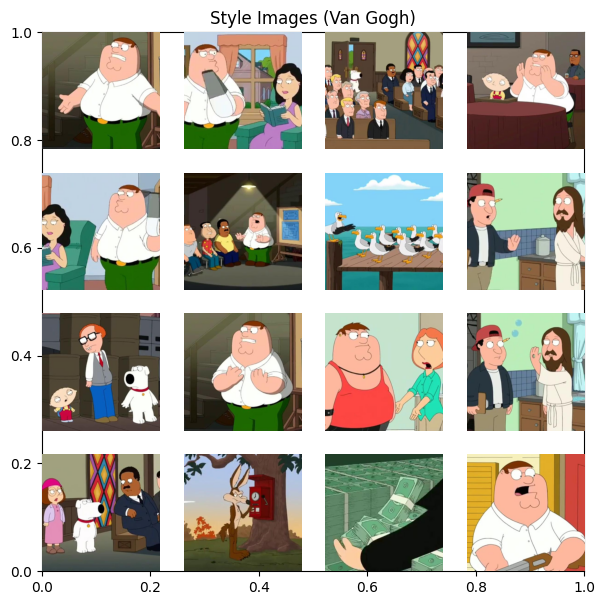

In [9]:
plt.figure(figsize=(7, 7))
plt.title("Style Images (Van Gogh)")
for i, image in enumerate(style_images.shuffle(10000).take(16)):
    ax = plt.subplot(4, 4, i + 1)
    ax.imshow(image[0])
    plt.axis("off")
plt.show()

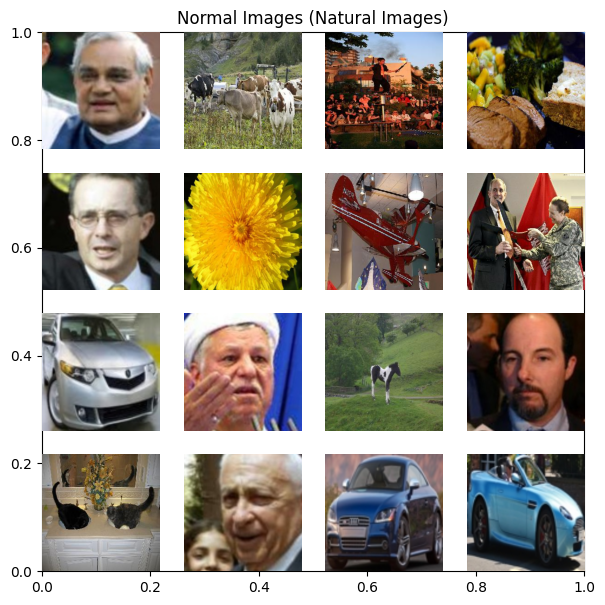

In [10]:
plt.figure(figsize=(7, 7))
plt.title("Normal Images (Natural Images)")
for i, image in enumerate(normal_images.shuffle(10000).take(16)):
    ax = plt.subplot(4, 4, i + 1)
    ax.imshow(image[0])
    plt.axis("off")
plt.show()

## Instance Normalization layer rewrite
Original source used InstanceNormalization layer from `tensorflow_addons` which have recently reached their end of life. In order to use the same functionality, I've rewritten the layer in `tf.keras`.

In [2]:
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon: float = 1e-5, gamma_initializer="ones", beta_initializer="zeros", **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.beta, self.gamma = None, None
        self.epsilon = epsilon
        self.gamma_initializer = gamma_initializer
        self.beta_initializer = beta_initializer

    def build(self, input_shape):
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer=self.gamma_initializer,
            trainable=True,
            name="gamma"
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer=self.beta_initializer,
            trainable=True,
            name="beta"
        )
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

    def get_config(self) -> dict:
        config = super(InstanceNormalization, self).get_config()
        config.update({"epsilon": self.epsilon})
        return config

## Upsample and Downsample Layers
Model bases on downsampling and upsampling the images. For this exact purpose, we need to define these layers below.

In [3]:
output_channels = len(["Red", "Green", "Blue"])  # RGB

def downsample(filters: int, size: int, instance_norm: bool = True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding="same", kernel_initializer=initializer, use_bias=False))
    if instance_norm:
        result.add(InstanceNormalization(gamma_initializer=gamma_init))
    result.add(layers.LeakyReLU())
    return result


def upsample(filters: int, size: int, dropout: bool = False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding="same", kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization(gamma_initializer=gamma_init))
    if dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

## Generator Model initialization
Here's a quick recap of how the generator works:
1. Generator takes 256x256x3 image and converts into 1x1x512 vector
2. That vector is upsampled to 256x256x3
3. To prevent vanishing gradient problem, skip connections are created and the model is returned

In [4]:
class Generator:
    def __init__(self):
        self.initializer = tf.random_normal_initializer(0., 0.02)
        self.inputs = layers.Input([256, 256, 3])
        self.outputs = None
        self.model = None
        self.down_stack, self.up_stack = None, None
        self.prepare_stacks()

    def __call__(self, inputs, training: bool = True):
        if not self.model:
            self.build()
        return self.model(inputs, training=training)

    def prepare_stacks(self):
        self.down_stack = [downsample(64, 4),  # 128x128x64
                           downsample(128, 4),  # 64x64x128
                           downsample(256, 4),  # 32x32x256
                           downsample(512, 4),  # 16x16x512
                           downsample(512, 4),  # 8x8x512
                           downsample(512, 4),  # 4x4x512
                           downsample(512, 4),  # 2x2x512
                           downsample(512, 4),  # 1x1x512
                           ]
        self.up_stack = [upsample(512, 4, dropout=True),  # 2x2
                         upsample(512, 4, dropout=True),  # 4x4
                         upsample(512, 4),  # 8x8
                         upsample(256, 4),  # 16x16
                         upsample(128, 4),  # 32x32
                         upsample(64, 4),  # 64x64
                         upsample(32, 4),  # 128x128
                         ]

    def build(self) -> keras.Model:
        last_layer = layers.Conv2DTranspose(output_channels, 4,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=self.initializer,
                                            activation='tanh')

        x = self.inputs
        skips = []
        for down in self.down_stack:
            x = down(x)
            skips.append(x)
        skips = reversed(skips[:-1])

        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = layers.Concatenate()([x, skip])
        self.outputs = last_layer(x)
        self.model = keras.Model(inputs=self.inputs, outputs=self.outputs)
        return self.model

## Discriminator Model initialization
In this section I am going to build the discriminator model. This Discriminator is a CNN based classifier. Its main purpose is to determine whether given image is real or generated.

In [5]:
class Discriminator:
    def __init__(self):
        self.initializer = tf.random_normal_initializer(0., 0.02)
        self.gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
        self.inputs = layers.Input([256, 256, 3], name="input_image")
        self.outputs = None
        self.model = None
    
    def build(self) -> keras.Model:
        down_layer1 = downsample(32, 4, False)(self.inputs)   # 128x128x32
        down_layer2 = downsample(64, 4, False)(down_layer1)   # 64x64x64
        down_layer3 = downsample(128, 4, False)(down_layer2)  # 32x32x128
        
        zero_pad_layer1 = layers.ZeroPadding2D()(down_layer3)
        conv_layer = layers.Conv2D(512, 4, strides=1,
                             kernel_initializer=self.initializer,
                             use_bias=False)(zero_pad_layer1)
        
        norm_layer = InstanceNormalization(gamma_initializer=self.gamma_init)(conv_layer)
        leaky_relu_layer = layers.LeakyReLU()(norm_layer)
        zero_pad_layer2 = layers.ZeroPadding2D()(leaky_relu_layer)
        
        self.outputs = layers.Conv2D(1, 4, strides=1, kernel_initializer=self.initializer)(zero_pad_layer2)
        self.model = keras.Model(inputs=self.inputs, outputs=self.outputs)
        return self.model

## Generators and Discriminators initialization  

In [6]:
style_generator = Generator().build() # generates styled paintings using natural images
photo_generator = Generator().build() # generates natural images using styled paintings

style_discriminator = Discriminator().build() # determines whether generated styled painting is real or generated
photo_discriminator = Discriminator().build() # determines whether natural image is real or generated

## Visualizing the models
Requires `Graphviz` to be installed!
> If you want to export the models to SVG, you can uncomment the second line in cells below. This will cause _ValueError_, however the `.svg` file will be created regardless.

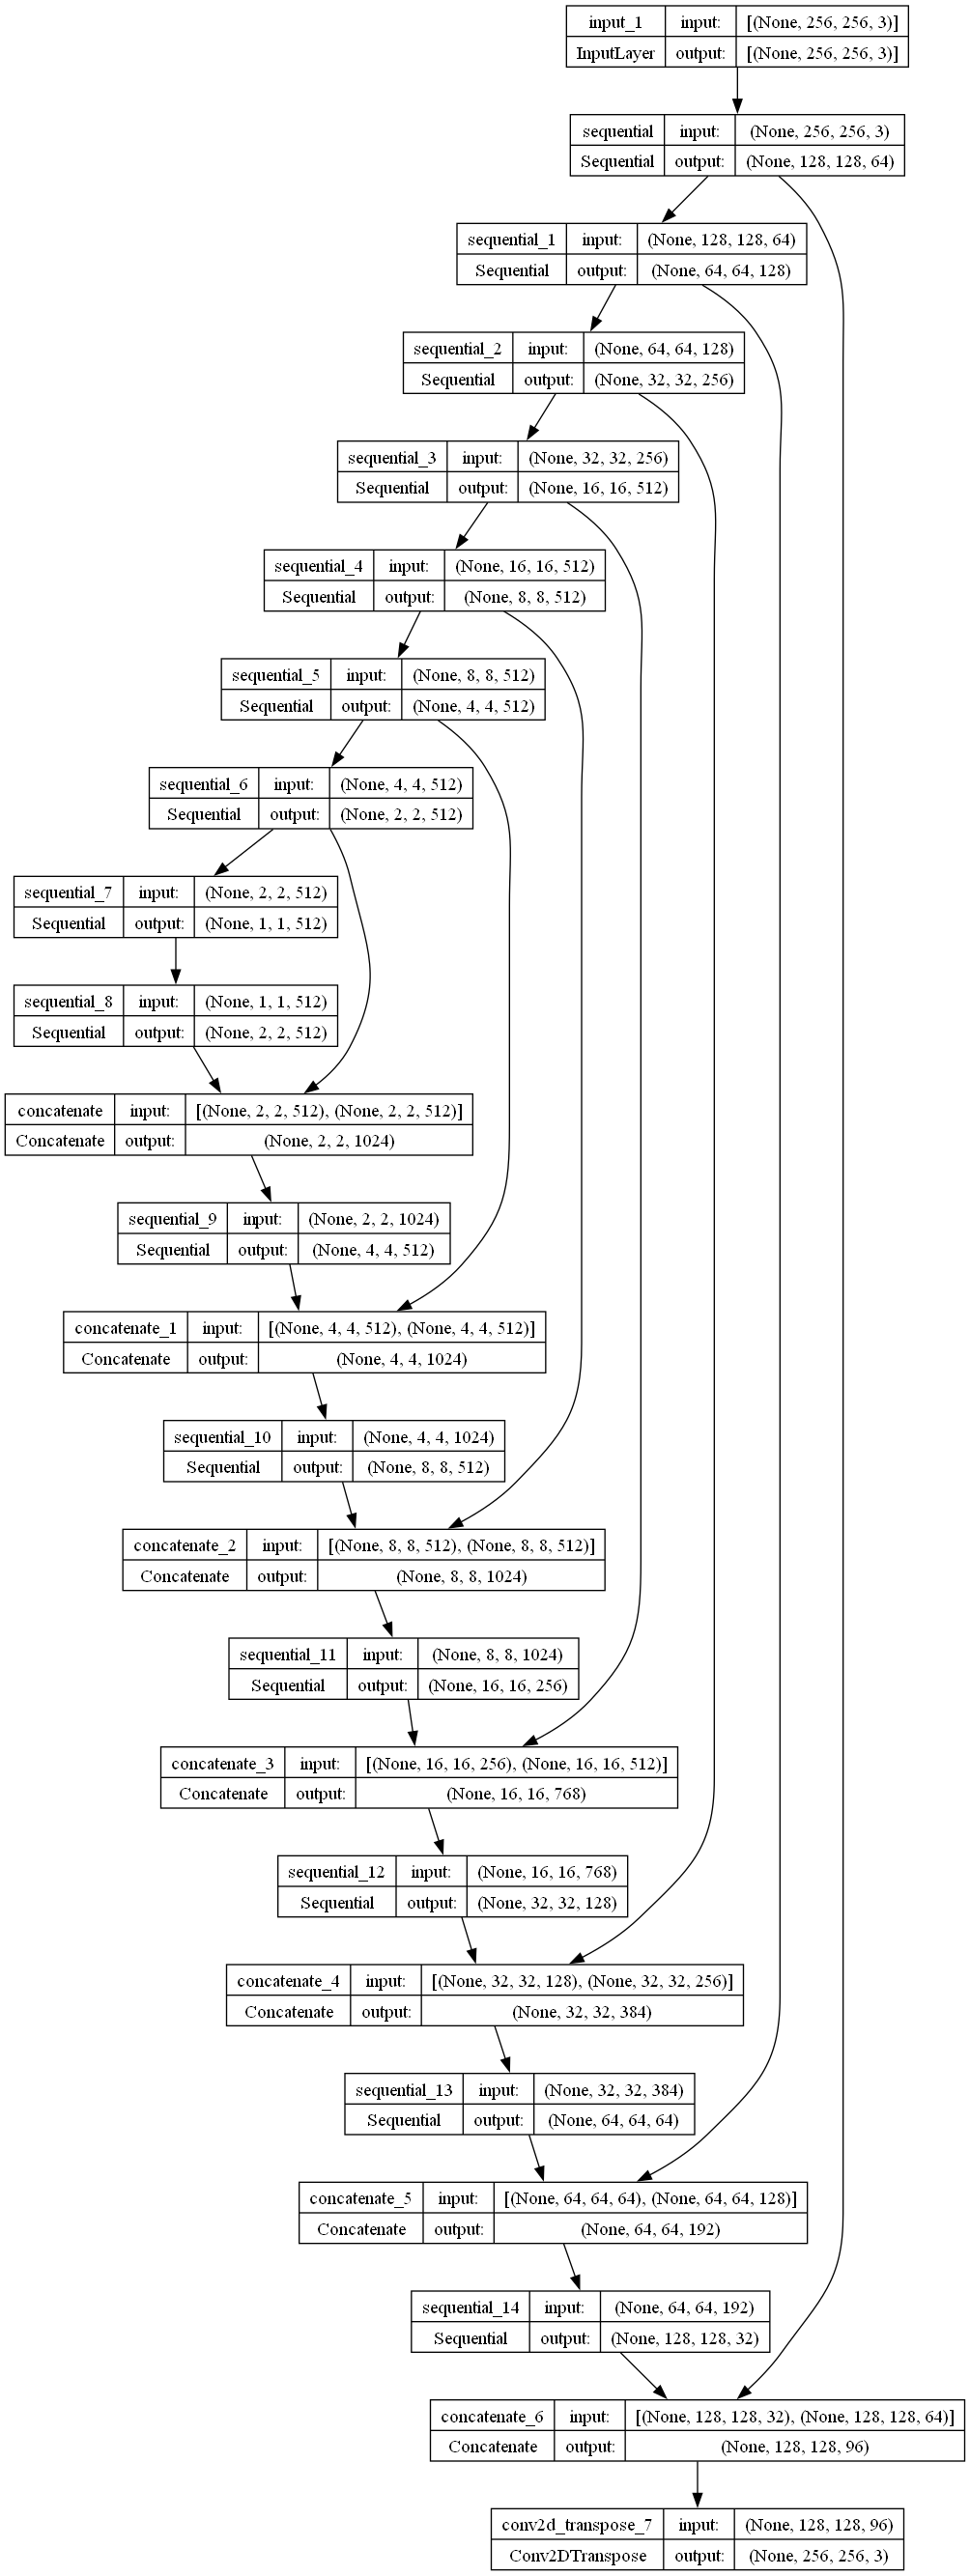

In [7]:
keras.utils.plot_model(style_generator, show_shapes=True, show_layer_names=True)
# keras.utils.plot_model(style_generator, to_file="../docs/models/cyclegan_generator.svg", show_shapes=True, show_layer_names=True)

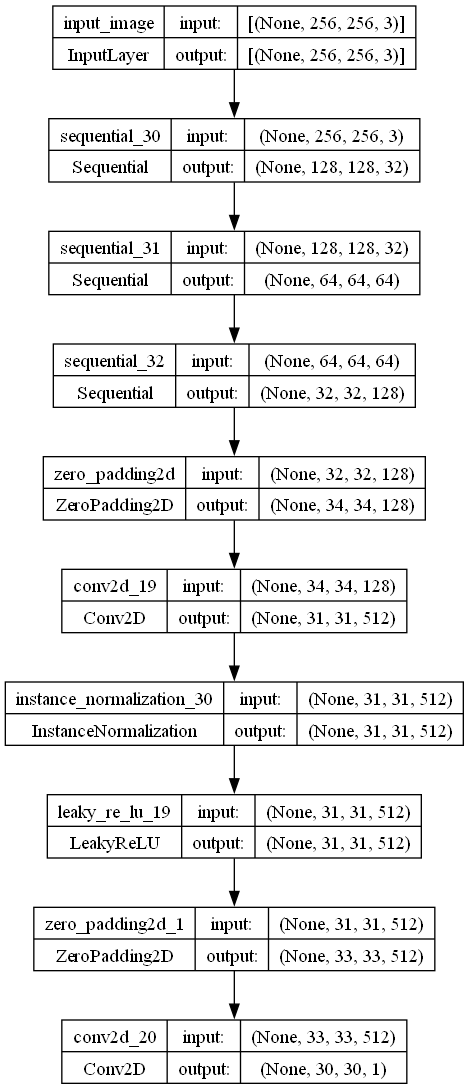

In [8]:
keras.utils.plot_model(style_discriminator, show_shapes=True, show_layer_names=True)
# keras.utils.plot_model(style_discriminator, to_file="../docs/models/cyclegan_discriminator.svg", show_shapes=True, show_layer_names=True)

### Building CycleGAN Model
Here we define the structure of CycleGAN model. Training process will be as follows:
1. Creating fake photos, same photos and cycled photos that will be used in order to compute loss
2. Discriminators decide whether the generated images are real or fake
3. Based on computed losses, gradients are calculated and applied to networks

In [18]:
class CycleGAN(keras.Model):
    def __init__(self, style_gen: keras.Model, photo_gen: keras.Model,
                 style_disc: keras.Model, photo_disc: keras.Model, lambda_cycle: int = 10):
        super(CycleGAN, self).__init__()
        self.style_gen = style_gen
        self.style_disc = style_disc
        self.photo_gen = photo_gen
        self.photo_disc = photo_disc
        self.lambda_cycle = lambda_cycle
        self.photo_gen_optimizer, self.photo_disc_optimizer = None, None
        self.style_gen_optimizer, self.style_disc_optimizer = None, None
        self.identity_loss_fn, self.cycle_loss_fn = None, None
        self.disc_loss_fn, self.gen_loss_fn = None, None

    def compile (self, style_gen_optimizer, photo_gen_optimizer, style_disc_optimizer, photo_disc_optimizer,
                gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn, **kwargs):
        super(CycleGAN, self).compile(**kwargs)
        self.style_gen_optimizer = style_gen_optimizer
        self.photo_gen_optimizer = photo_gen_optimizer
        self.style_disc_optimizer = style_disc_optimizer
        self.photo_disc_optimizer = photo_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data) -> dict:
        real_style, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Photo -> Styled -> Photo
            fake_style = self.style_gen(real_photo, training=True)
            cycled_photo = self.photo_gen(fake_style, training=True)

            # Styled -> Photo -> Styled
            fake_photo = self.photo_gen(real_style, training=True)
            cycled_style = self.style_gen(fake_photo, training=True)

            # Generator generates
            same_photo = self.photo_gen(real_photo, training=True)
            same_style = self.style_gen(real_style, training=True)

            # Discriminator decided
            disc_real_style = self.style_disc(real_style, training=True)
            disc_real_photo = self.photo_disc(real_photo, training=True)
            disc_fake_style = self.style_disc(fake_style, training=True)
            disc_fake_photo = self.photo_disc(fake_photo, training=True)

            # Generator loss
            style_gen_loss = self.gen_loss_fn(disc_fake_style)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Total cycle loss
            total_cycle_loss = self.cycle_loss_fn(real_style, cycled_style, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # Total loss
            total_style_gen_loss = style_gen_loss + total_cycle_loss + self.identity_loss_fn(real_style, same_style, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Discriminator loss
            style_disc_loss = self.disc_loss_fn(disc_real_style, disc_fake_style)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculating gradients of networks
        style_generator_gradients = tape.gradient(total_style_gen_loss, self.style_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.photo_gen.trainable_variables)
        style_discriminator_gradients = tape.gradient(style_disc_loss, self.style_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.photo_disc.trainable_variables)

        self.style_gen_optimizer.apply_gradients(zip(style_generator_gradients, self.style_gen.trainable_variables))
        self.photo_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.photo_gen.trainable_variables))

        self.style_disc_optimizer.apply_gradients(zip(style_discriminator_gradients,
                                                      self.style_disc.trainable_variables))
        self.photo_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                      self.photo_disc.trainable_variables))

        return {
            "style_gen_loss": total_style_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "style_disc_loss": style_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Defining loss functions

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)


def discriminator_loss(real, generated) -> tf.Tensor:  # avg of real and generated images loss
    real_loss = cross_entropy(tf.ones_like(real), real)
    generated_loss = cross_entropy(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) / 2


def generator_loss(generated) -> tf.Tensor:  # generated images loss
    return cross_entropy(tf.ones_like(generated), generated)


def cycle_loss(real_image, cycled_image, _lambda: float) -> tf.Tensor:  # generated images loss
    return tf.reduce_mean(tf.abs(real_image - cycled_image)) * _lambda


def identity_loss(real_image, same_image, _lambda: float) -> tf.Tensor:
    return tf.reduce_mean(tf.abs(real_image - same_image)) * _lambda

## Defining optimizers
Adam optimizer's adaptive learning rate, efficient handling of noisy and sparse gradients and ease of use make it a great choice for complex and dynamic training process in GANs.

In [20]:
style_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

style_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

### CycleGAN initialization and compilation

In [21]:
with tf.device(device):
    model = CycleGAN(style_gen=style_generator, photo_gen=photo_generator,
                    style_disc=style_discriminator, photo_disc=photo_discriminator)

    model.compile(style_gen_optimizer=style_generator_optimizer, photo_gen_optimizer=photo_generator_optimizer,
                  style_disc_optimizer=style_discriminator_optimizer,
                  photo_disc_optimizer=photo_discriminator_optimizer, gen_loss_fn=generator_loss,
                  disc_loss_fn=discriminator_loss, cycle_loss_fn=cycle_loss, identity_loss_fn=identity_loss)

### Training the CycleGAN model
- loads the saved weights if available
- trains the model for given amount of epochs

In [22]:
epochs = 100

with tf.device(device):
    # if os.path.exists("../models/cartoon_model.weights.h5"):
    #     model.load_weights("../models/cartoon_model.weights.h5")
    #     print("Loaded .weights.h5 file!")
    model.fit(tf.data.Dataset.zip((style_images, normal_images)), epochs=epochs)
    style_generator.save_weights("../models/cartoon.weights.h5")
    model.save_weights("../models/cartoon_model.weights.h5")

Epoch 1/100
146/146 [==============================] - 96s 380ms/step - style_gen_loss: 10.1758 - photo_gen_loss: 9.3939 - style_disc_loss: 0.5424 - photo_disc_loss: 0.5617
Epoch 2/100
146/146 [==============================] - 57s 390ms/step - style_gen_loss: 5.0502 - photo_gen_loss: 4.8260 - style_disc_loss: 0.4664 - photo_disc_loss: 0.5685
Epoch 3/100
146/146 [==============================] - 57s 392ms/step - style_gen_loss: 4.5152 - photo_gen_loss: 4.5193 - style_disc_loss: 0.6071 - photo_disc_loss: 0.6185
Epoch 4/100
146/146 [==============================] - 57s 392ms/step - style_gen_loss: 4.2563 - photo_gen_loss: 4.3175 - style_disc_loss: 0.6341 - photo_disc_loss: 0.6428
Epoch 5/100
146/146 [==============================] - 58s 396ms/step - style_gen_loss: 4.1283 - photo_gen_loss: 4.2049 - style_disc_loss: 0.6428 - photo_disc_loss: 0.6481
Epoch 6/100
146/146 [==============================] - 58s 397ms/step - style_gen_loss: 4.0125 - photo_gen_loss: 4.1028 - style_disc_loss: 

In [23]:
# style_generator.save_weights("../models/cartoon.weights.h5")  # in case saving above fails (example: lack of memory)

In [24]:
# model.save_weights("../models/cartoon_model.weights.h5")  # in case saving above fails (example: lack of memory)

### Sample painting generation

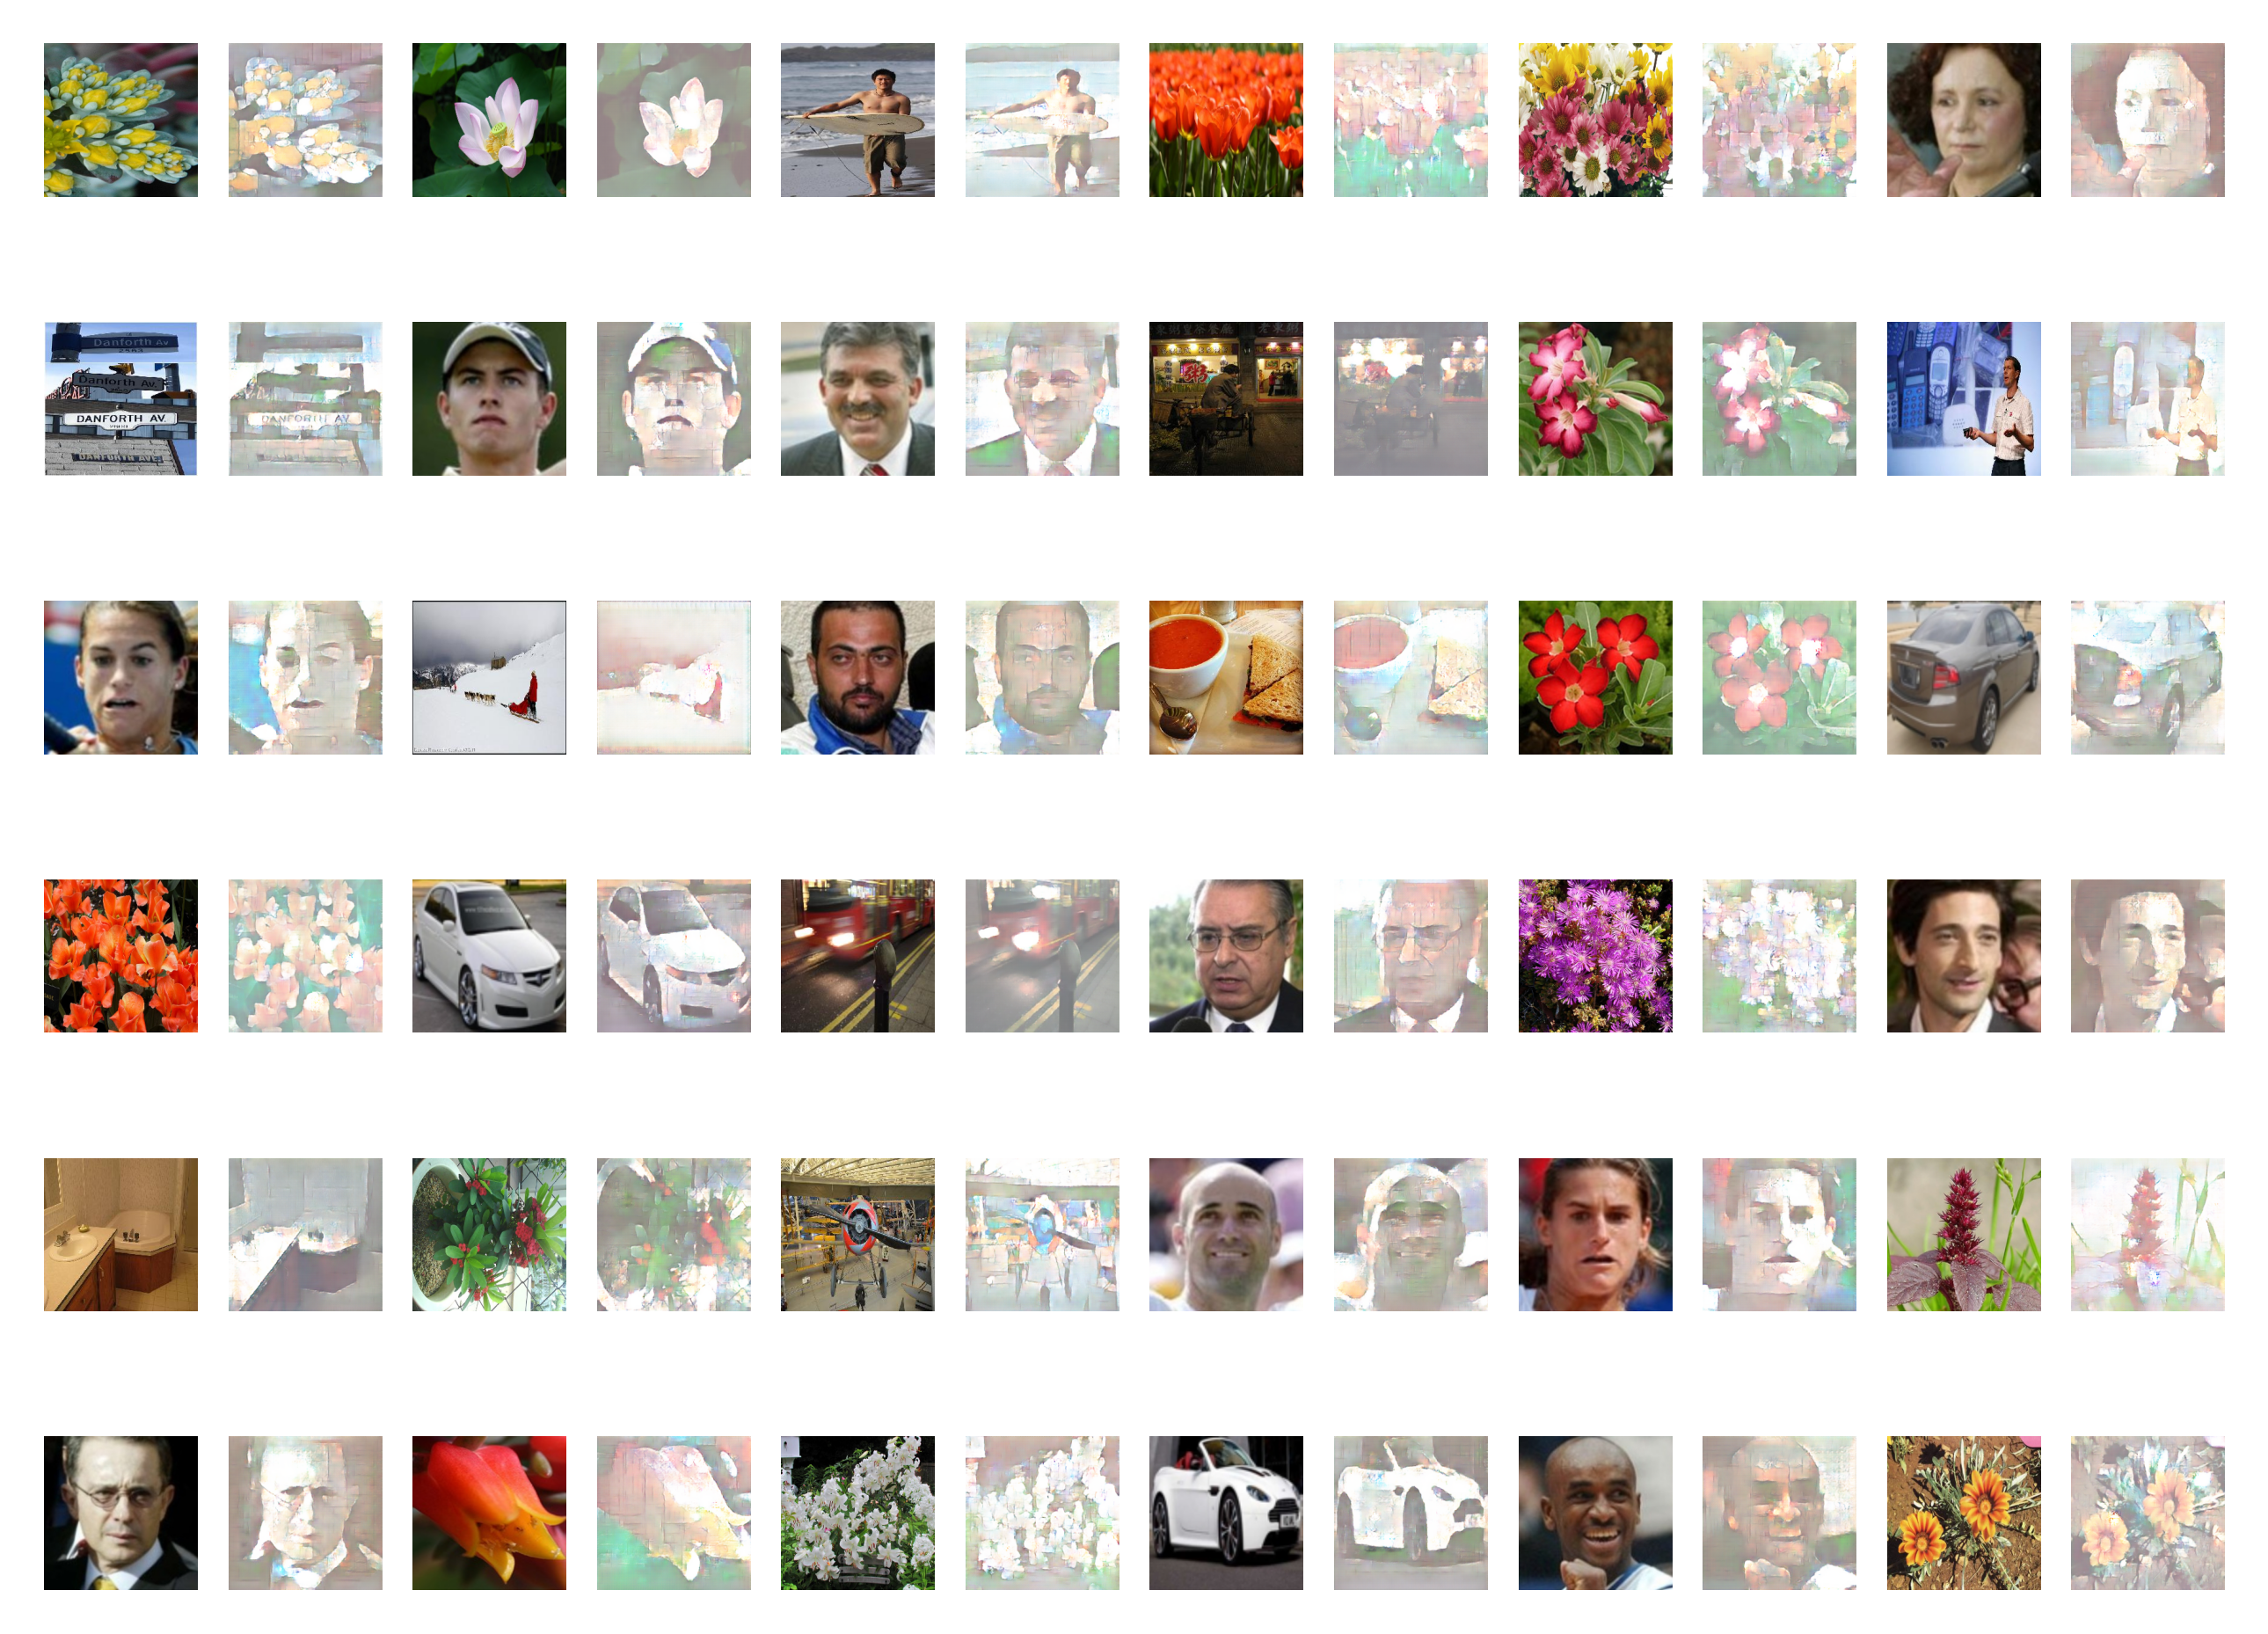

In [25]:
plt.figure(dpi=500)
for i, image in enumerate(normal_images.shuffle(10000).take(36)):
    plt.subplot(6, 12, 2 * i + 1)
    plt.imshow(image[0])
    plt.axis("off")
    prediction = style_generator(image, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    plt.subplot(6, 12, 2 * (i + 1))
    plt.imshow(prediction)
    plt.axis("off")

plt.savefig("../tmp/cartoon_result.png")
plt.show()